# Imports

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime

# feature transformation and preprocessing
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Auxiliary Functions

The function below will enable us to observe the missing values as a percentage per feature.

In [2]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent],
                              axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

The function below will enable us to plot a histogram

In [3]:
def plot_histogram(df, column, b="auto"):
    # funtion to print histogram
    # with mean and median
    # using distplot

    # set the histogram, mean and median
    # g = sns.distplot(df[column],
    #                  kde=False,
    #                  bins=b)
    g = sns.histplot(df[column], kde=False, bins=b)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column),
               size=14)
    plt.ylabel("Count",
               size=14)
    plt.title("Distribution of {}".format(column),
              size=16)
    plt.legend(["mean", "median"])

    return g


The function below will enable us to plot distribution

In [4]:
def plot_distribution(df, target, column_values, column_name):
    # funtion to print distribution of a continuous variable
    # for categorical data

    for value in column_values:
        subset = df[
            df[column_name] == value]
        g = sns.kdeplot(subset[target],
                        label=value,
                        linewidth=3)

    # set title, legends and labels
    plt.ylabel("Density",
               size=14)
    plt.xlabel("{}".format(target),
               size=14)
    plt.title("Distribution of {} per {}"
              .format(target, column_name),
              size=16)

    return g

The function below will enable us to create list of provinces

In [5]:
def create_province_list(df, country_name):
    # funtion to create list of provinces
    # for a given country name
    indexed_train = df.set_index("country")
    province_list = list(
        indexed_train
        .loc[country_name]["province"]
        .unique())
    return province_list

# Understand & Clean & Format Data

In [6]:
train = pd.read_csv("../data/train/train.csv") 
test = pd.read_csv("../data/test/test.csv")
train.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
6492,US,"This bottling is extremely chalky on the nose,...",1772 Pacific Wind,90,48.0,California,Edna Valley,Central Coast,Matt Kettmann,@mattkettmann,Tolosa 2015 1772 Pacific Wind Chardonnay (Edna...,Chardonnay,Tolosa
1086,US,"A bit thin and acidic, but charming for its dr...",York Creek,87,30.0,California,California,California Other,NaN,NaN,Ridge 2008 York Creek Zinfandel (California),Zinfandel,Ridge
5292,Spain,There's no denying this wine's force. It's 15%...,NaN,93,70.0,Northern Spain,Toro,NaN,Michael Schachner,@wineschach,Pintia 2009 Toro,Tinta de Toro,Pintia
2203,France,"Plan de Dieu is a broad, stony plain near Gigo...",Domaine du Père Hugues Plan de Dieu,89,15.0,Rhône Valley,Côtes du Rhône Villages,NaN,Joe Czerwinski,@JoeCz,Louis Bernard 2015 Domaine du Père Hugues Plan...,Rhône-style Red Blend,Louis Bernard
3594,Italy,Aged only in stainless steel to preserve its f...,Beta Delta,88,25.0,Northeastern Italy,Vigneti delle Dolomiti,NaN,NaN,NaN,Alois Lageder 2009 Beta Delta Red (Vigneti del...,Red Blend,Alois Lageder


In [7]:
print("There are {} rows and {} columns in the train dataset."
      .format(train.shape[0], train.shape[1]))

There are 9000 rows and 13 columns in the train dataset.


In [8]:
print("There are {} rows and {} columns in the test dataset."
      .format(test.shape[0], test.shape[1]))

There are 1000 rows and 13 columns in the test dataset.


## Descriptive statistics & information about datasets

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   designation            6455 non-null   object 
 3   points                 9000 non-null   int64  
 4   price                  8403 non-null   float64
 5   province               8994 non-null   object 
 6   region_1               7505 non-null   object 
 7   region_2               3469 non-null   object 
 8   taster_name            7223 non-null   object 
 9   taster_twitter_handle  6888 non-null   object 
 10  title                  9000 non-null   object 
 11  variety                9000 non-null   object 
 12  winery                 9000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 914.2+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                1000 non-null   object 
 1   description            1000 non-null   object 
 2   designation            716 non-null    object 
 3   points                 1000 non-null   int64  
 4   price                  920 non-null    float64
 5   province               1000 non-null   object 
 6   region_1               831 non-null    object 
 7   region_2               384 non-null    object 
 8   taster_name            792 non-null    object 
 9   taster_twitter_handle  756 non-null    object 
 10  title                  1000 non-null   object 
 11  variety                1000 non-null   object 
 12  winery                 1000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB


In [11]:
train.describe()

,points,price
count,9000.000000,8403.000000
mean,88.455222,35.532191
std,3.025945,40.750683
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


Majority of the features are categorical and we have some missing data in the both datasets. Machine learning models can only work with numerical and non-empty values. Thus we are going to develop strategies in Feature Engineering to impute the missing data and transform categorical values into the numeric values.

In [12]:
test.describe()

,points,price
count,1000.000000,920.000000
mean,88.503000,34.675000
std,3.067475,42.240874
min,80.000000,7.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,41.000000
max,97.000000,1000.000000


## Description of features and target

In [13]:
train.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,US,"Expressive aromas of smoke, embers and blue fr...",NaN,88,35.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Damsel 2013 Syrah (Columbia Valley (WA)),Syrah,Damsel
1,South Africa,"Soft mint, spice, cocoa and smoke on the nose ...",Redhill,89,30.0,Stellenbosch,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Simonsig 2005 Redhill Pinotage (Stellenbosch),Pinotage,Simonsig
2,Portugal,"An elegant, finely rounded wine, with firm tan...",NaN,90,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta de la Rosa 2008 Red (Douro),Portuguese Red,Quinta de la Rosa
3,South Africa,Winemaker: Louis Nel. This Cab-Shiraz blend is...,Cape Winemakers Guild Rapscallion,91,NaN,Stellenbosch,NaN,NaN,Lauren Buzzeo,@laurbuzz,Louis Nel 2015 Cape Winemakers Guild Rapscalli...,Cabernet Sauvignon-Shiraz,Louis Nel
4,Portugal,"Lightly wood aged and spicy, this is a fine re...",Casa Américo Branco Reserva,90,NaN,Dão,NaN,NaN,Roger Voss,@vossroger,Seacampo 2014 Casa Américo Branco Reserva Encr...,Encruzado,Seacampo


In [14]:
train.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
7671,France,"Produced from 90% Merlot and 10% Malbec, this ...",NaN,89,22.0,Bordeaux,Blaye Côtes de Bordeaux,NaN,Roger Voss,@vossroger,Château Haut Colombier 2015 Blaye Côtes de Bo...,Bordeaux-style Red Blend,Château Haut Colombier
4940,US,"Exuberant in mousse, this wine is luxurious an...",Wedding Cuvée,94,44.0,California,Green Valley,Sonoma,Virginie Boone,@vboone,Iron Horse 2013 Wedding Cuvée Sparkling (Green...,Sparkling Blend,Iron Horse
1425,Italy,"This blend of 70% Cabernet Sauvignon, 20% Peti...",Millepassi,91,58.0,Tuscany,Bolgheri,NaN,Kerin O’Keefe,@kerinokeefe,Donna Olimpia 1898 2011 Millepassi (Bolgheri),Red Blend,Donna Olimpia 1898
5041,US,"A deep, stony minerality persists from nose to...",Luminous,90,18.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Anthony Nappa 2014 Luminous Riesling (Finger L...,Riesling,Anthony Nappa
6646,France,"A grassy, green wine, although with some weigh...",NaN,86,12.0,Southwest France,Côtes de Gascogne,NaN,Roger Voss,@vossroger,Domaine du Tariquet 2012 Sauvignon Blanc (Côte...,Sauvignon Blanc,Domaine du Tariquet


With some intuition, expert knowledge and help of Google here are the explanation of features and target:

- <b>country:</b> Origin of the wine producer
- <b>description:</b> Presentment of the taster to describe the wine
- <b>designation:</b> Name of the wine given to the wine by the producer, sometimes used interchangeably with vineyard. Usually available in the title.
- <b>points:</b> Our target value, representing score of a particular wine received from a taster. An important remark is, a wine may receive different points from the same taster.
- <b>price:</b> Price of the wine
- <b>region_1:</b> Official definition of the place where the grapes for a wine are grown
- <b>region_2:</b> Official definition of the place where the grapes for a wine are grown
- <b>taster_name:</b> The taster, as obvious assigns points to the wine
- <b>title:</b> Name of the wine, as available on the label
- <b>variety:</b> Grape variety of the wine
- <b>winery:</b> name of the wine producer

## Missing values of the datasets

In [15]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
region_2,5531,61.5
designation,2545,28.3
taster_twitter_handle,2112,23.5
taster_name,1777,19.7
region_1,1495,16.6
price,597,6.6
country,6,0.1
province,6,0.1


In [16]:
missing_values_table(test)

Your selected dataframe has 13 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
region_2,616,61.6
designation,284,28.4
taster_twitter_handle,244,24.4
taster_name,208,20.8
region_1,169,16.9
price,80,8.0


Features that have missing values more than 50% will be dropped since they aren't likely to provide significant information to the machine learning model.

In this sample dataset, target value has no missing values, if we had some, we would drop all the missing values of the target to not to leak any data or distort the existing distribution of the target.

Considering above comments and looking at the missing values, region_2 will be dropped.

## Cardinality of the non-numeric features

High cardinality features may cause problems when we are training our model. Even though we transform each unique value of a categorical feature to a new feature, they may bring the curse of dimensionality. So, we are going to use the high cardinality features for adding new features, then we are going to remove them from the datasets.

In [17]:
object_columns = (train
                  .select_dtypes(include="object")
                  .columns)

for column in object_columns:
    print("{} has {} unique values."
          .format(column, 
                  train[column]
                  .nunique()))

country has 37 unique values.
description has 8948 unique values.
designation has 4913 unique values.
province has 236 unique values.
region_1 has 699 unique values.
region_2 has 17 unique values.
taster_name has 18 unique values.
taster_twitter_handle has 14 unique values.
title has 8937 unique values.
variety has 325 unique values.
winery has 5097 unique values.


<b>Cardinality</b> is the number of unique values that a feature has.

<b>We have some high-cardinality features:</b>

- description
- designation
- title
- winery

<b>We have some moderate-cardinality features:</b>

- province
- region_1
- variety

<b>We have some low-cardinality features:</b>

- country
- taster_name
- taster_twitter_handle

Description contains information about wine's color, taste and notes (like citrus, tannins). Title feature contains year of the wine produced. Variety has the information about if different type of grapes are blended or not. They can be used to extract more features.

High cardinality features will be dropped from the dataset, if not used for feature extraction.

Most frequent values of moderate and low cardinality features will be explored in the Exploratory Data Analysis.

## Unique values of taster_name and taster_twitter_handle

In [18]:
taster_names = train["taster_name"].unique()

for value in taster_names:
    print(value)

Sean P. Sullivan
Susan Kostrzewa
Roger Voss
Lauren Buzzeo
Joe Czerwinski
Michael Schachner
Jim Gordon
Kerin O’Keefe
Matt Kettmann
nan
Paul Gregutt
Virginie Boone
Anna Lee C. Iijima
Jeff Jenssen
Mike DeSimone
Anne Krebiehl MW
Alexander Peartree
Fiona Adams
Carrie Dykes


In [19]:
taster_twitter_handles = (train["taster_twitter_handle"]
                          .unique())

for value in taster_twitter_handles:
    print(value)

@wawinereport
@suskostrzewa
@vossroger
@laurbuzz
@JoeCz
@wineschach
@gordone_cellars
@kerinokeefe
@mattkettmann
nan
@paulgwine 
@vboone
@worldwineguys
@AnneInVino
@bkfiona


The objective is to show good prediction is possible using wine predictor, which is a machine learning model itself. A "good prediction" is possible with features of independent variables that are predictive of the points. 

So we do not want to use dependent features (like taster_twitter_handle and the taster_name) when building our model, because they are providing the same information to the model and possibly making it unnecessarily complicated. 

After some online research and making sure that each unique value of taster_twitter_handle is available in the taster_name feature, we can remove taster_twitter_handle to build a good predictor.

## Clean data

Our dataset contains duplicate rows, which I realized by following the clue of some of the rows having same descriptions.

- high-cardinality features not used in feature extraction: designation, winery
- high-percentage missing value features: region_2
- dependent features: taster_twitter_handle
- duplicate rows
- rows that have missing values in the points

Both datasets will be cleaned by dropping them.

In [20]:
def CleanData(df):
    """ 
        this function drops not used features and 
        duplicate rows and empty rows of target(poinst) 
        returns cleaned df
    """

    drop_columns = ["designation",
                    "winery",
                    "region_2",
                    "taster_twitter_handle"]
    interim_df = df.drop(columns=drop_columns)

    interim_df_2 = (interim_df
                    .drop_duplicates(ignore_index=True))
    
    cleaned_df = (interim_df_2
                  .dropna(subset=["points"], 
                          how="any")
                  .reset_index(drop=True))
    
    return cleaned_df

In [21]:
train_cleaned = CleanData(train)
test_cleaned = CleanData(test)

## Findings from Understand & Clean & Format Data

In [22]:
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the train dataset."
    .format(train_cleaned.shape[0], 
            train_cleaned.shape[1]))
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the test dataset."
    .format(test_cleaned.shape[0], 
            test_cleaned.shape[1]))

After the Understand & Clean & Format Data part 8948 rows and 9 columns left in the train dataset.
After the Understand & Clean & Format Data part 1000 rows and 9 columns left in the test dataset.


- Non-numeric features are grouped as high, moderate and low cardinality features. Moderate and low cardinality features will be explored in the *Exploratory Data Analysis* part.
- Features to be used for feature extraction (description, title and variety) in *Feature Engineering* part is pre-determined.
- Duplicate rows, not-used features and dependent features are dropped. As a result we are left with 8 features in total. 8948 are left in the train dataset, test dataset row count did not change.

# Exploratory Data Analysis

## Distribution of points

<Axes: title={'center': 'Distribution of points'}, xlabel='points', ylabel='Count'>

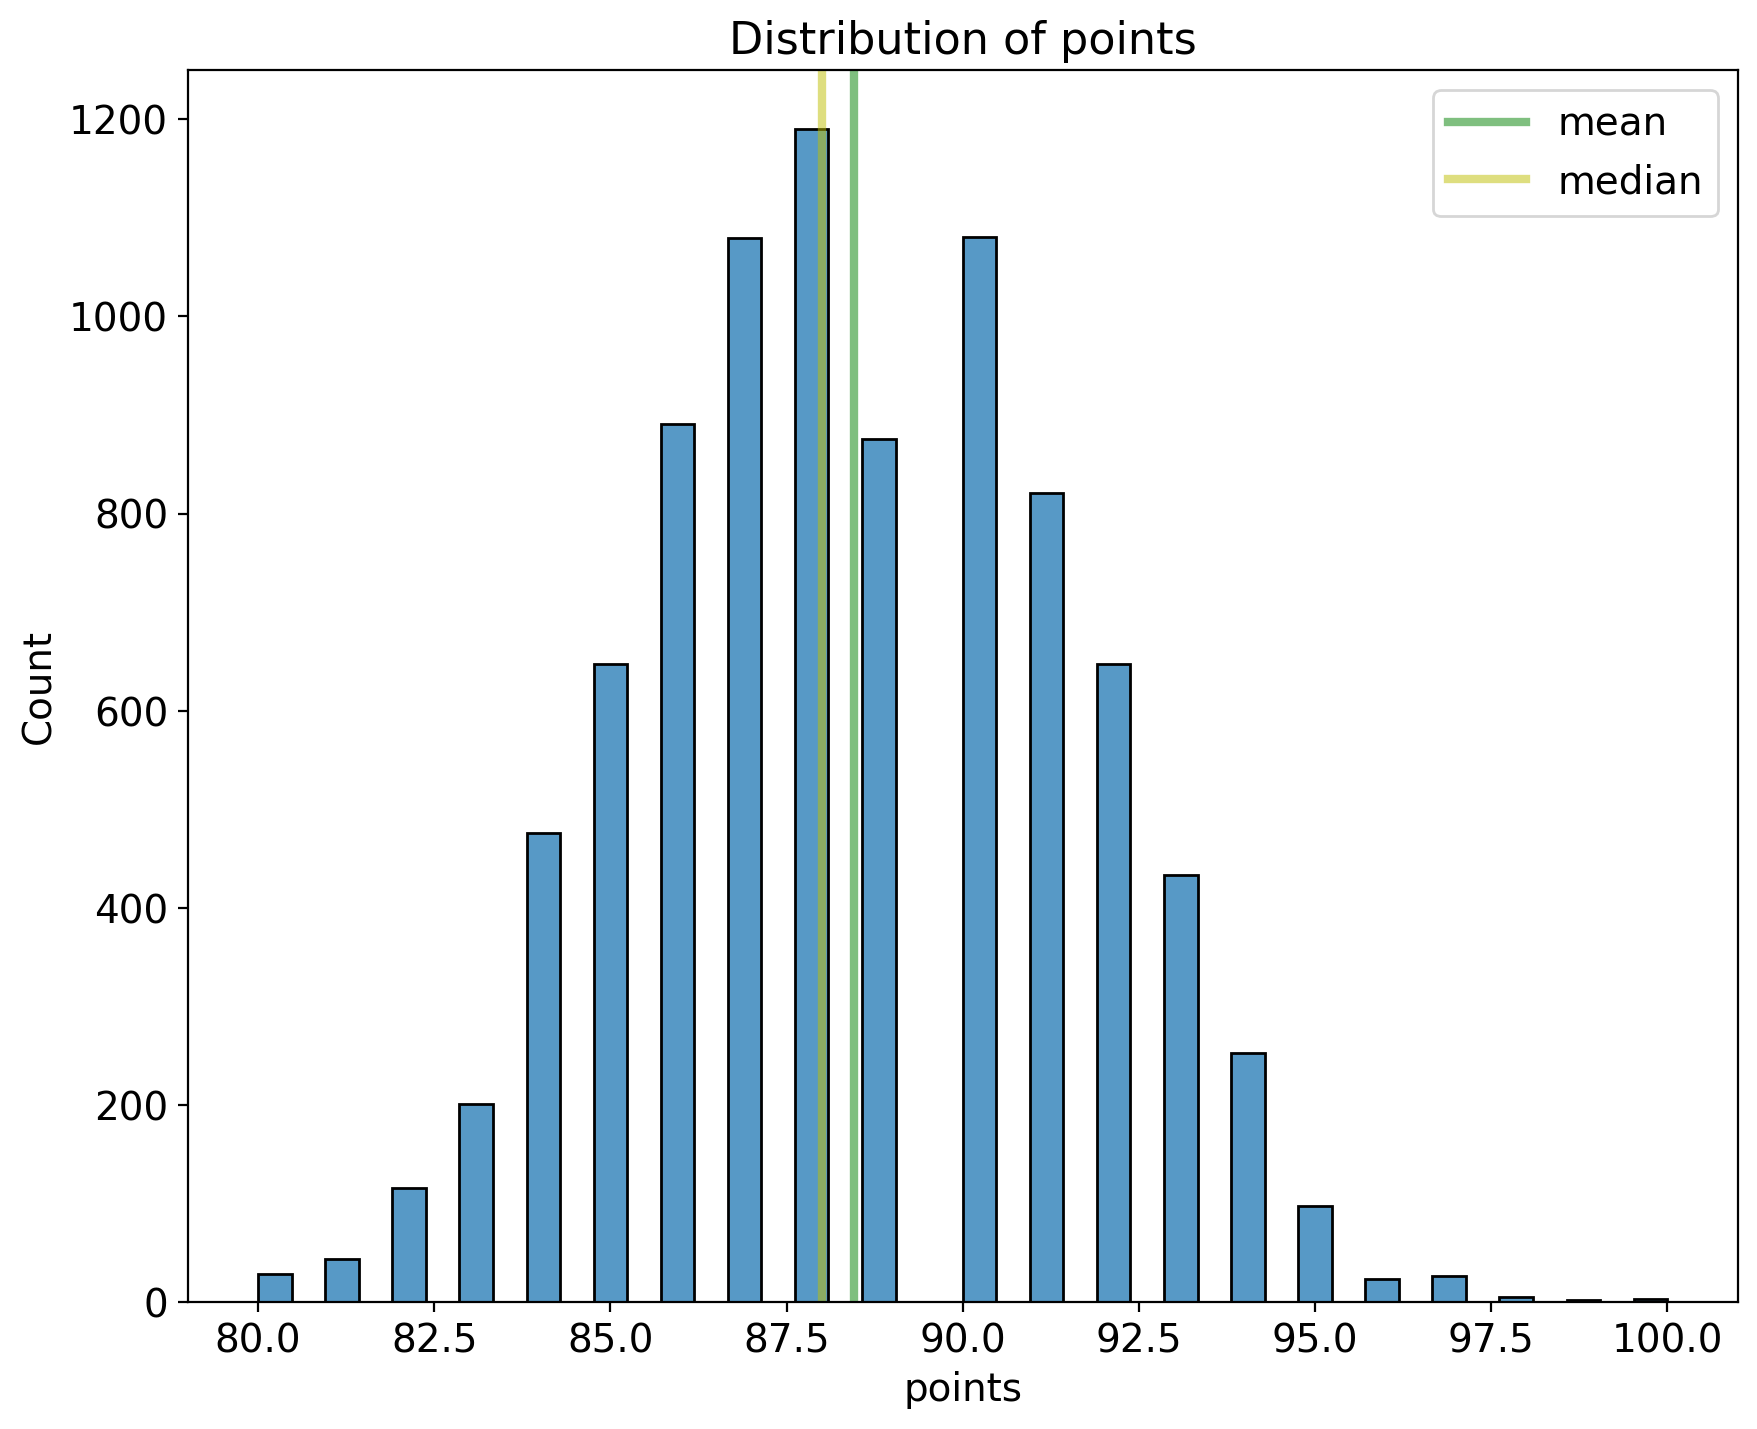

In [23]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "points")

***Distribution*** is a description of a variable's range and how data is spread in that range.

Points show a normal distribution (a bell shaped curve obvious) as expected from a random variable. Range of wine points are distributed between 80 and 100 with the average (mean) of 88.45 and median (the middle value) of 88. Moreover, standard deviation, a measure of spread of a data range, is 3.03. Based on this statistics, we can confidently say that:

* 68% of the points lie in the 85.5 - 91.5 range
* 95% of the points lie in the 82.5 - 94.5 range
* 99% of the points lie in the 79.5 - 97.5 range

Alternatively, we can see the points as a classification of wines and interpret points as different classes according to [wine searcher](https://www.wine-searcher.com/critics-17-wine+enthusiast):

* 98–100: Classic
* 94–97: Superb
* 90–93: Excellent
* 87–89: Very good
* 83–86: Good
* 80–82: Acceptable

However, this would be different wine predictor, which we will not touch is scope of this project.

## Distribution of price

<Axes: title={'center': 'Distribution of price'}, xlabel='price', ylabel='Count'>

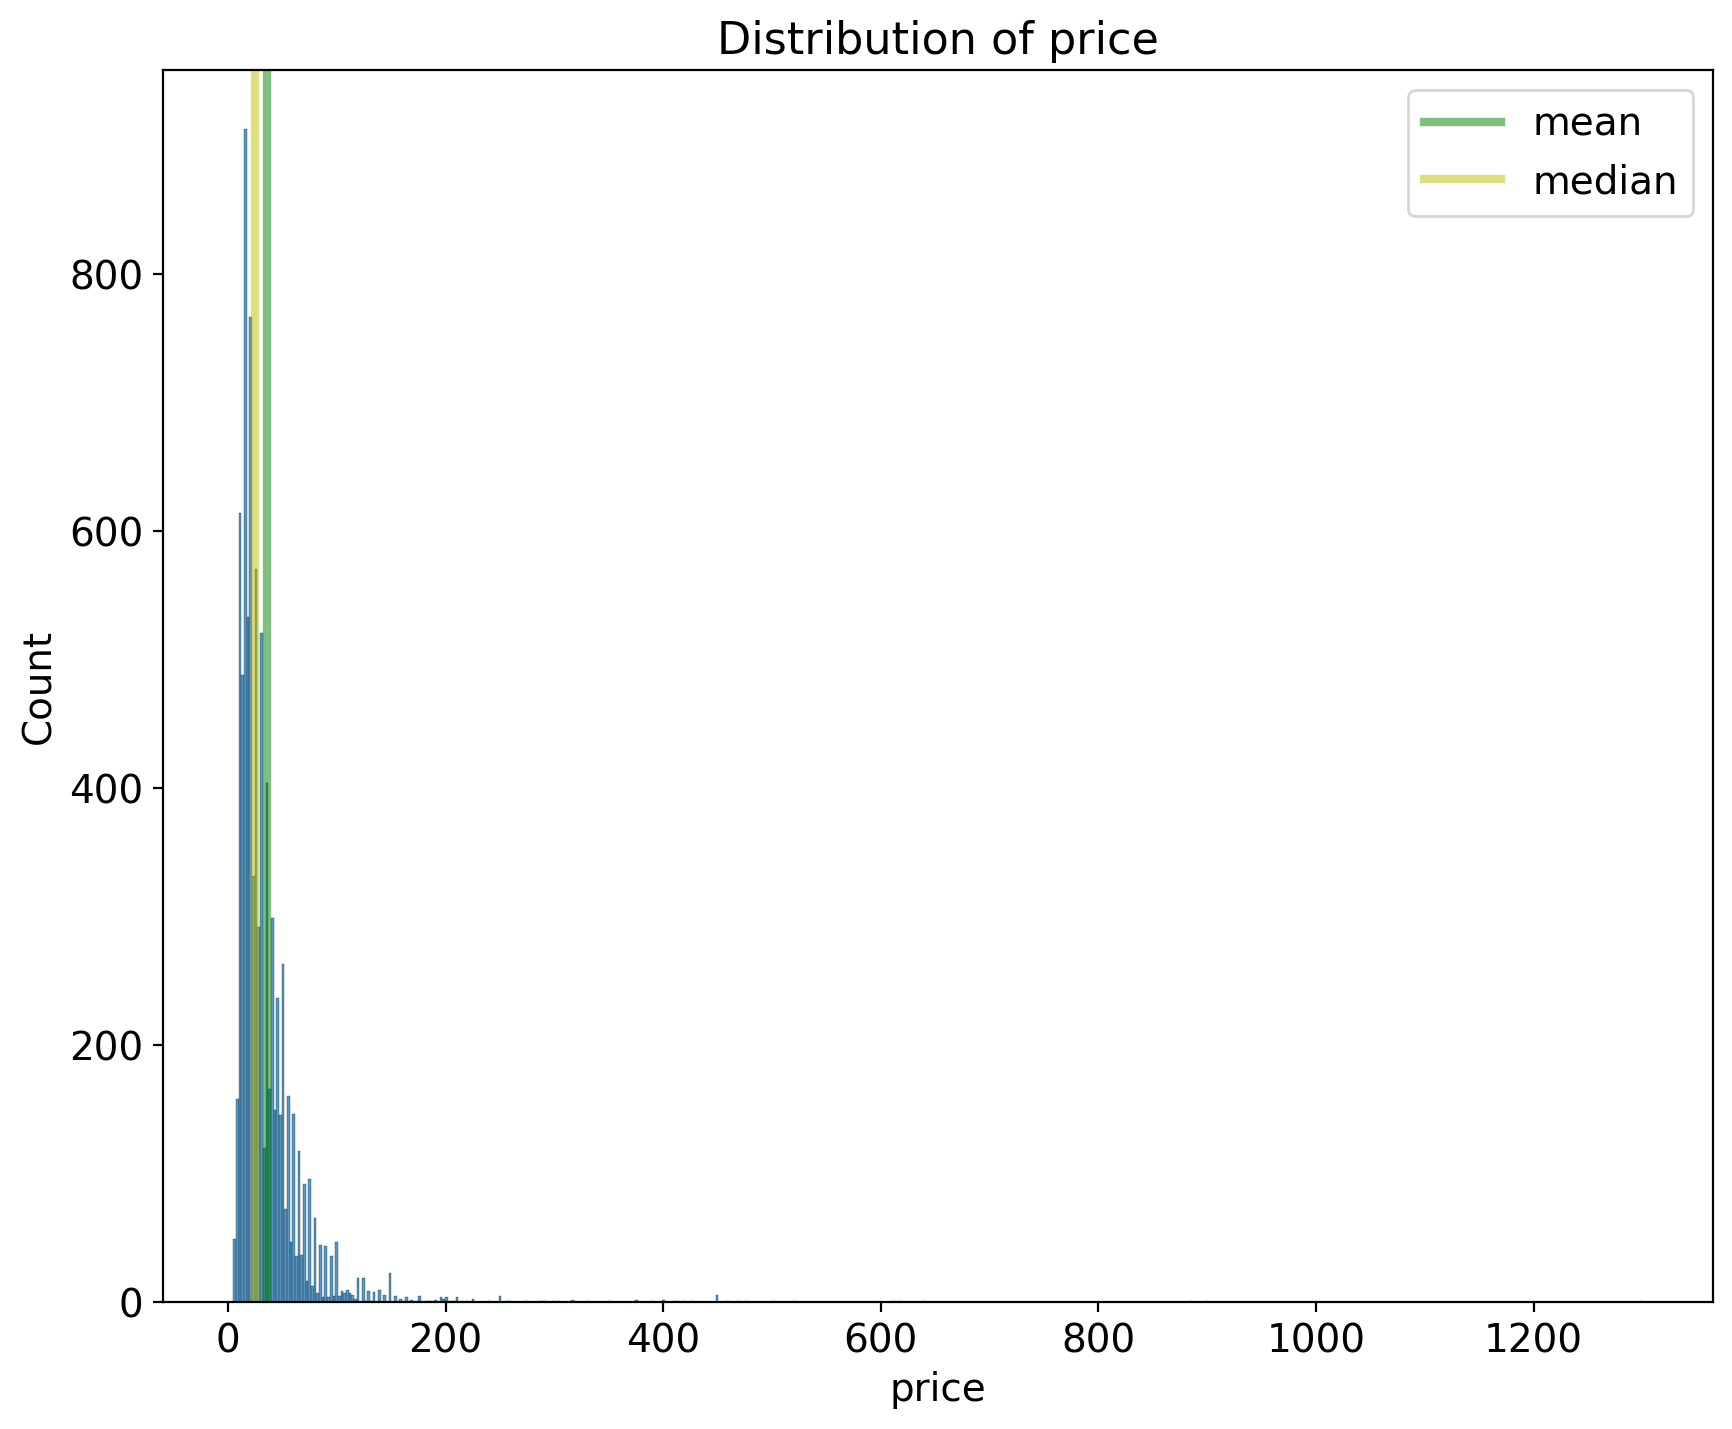

In [24]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "price")

Price is concentrated between the range 0-200, which is defined as ***right-skewed*** distribution. 

This can be interpreted as majority of the wine prices are lower than 200 and most of them are cheaper wine, explaining the spike near 0.

This is also an indicator of we have a few very expensive wines, extending price to 1200.

(0.0, 200.0)

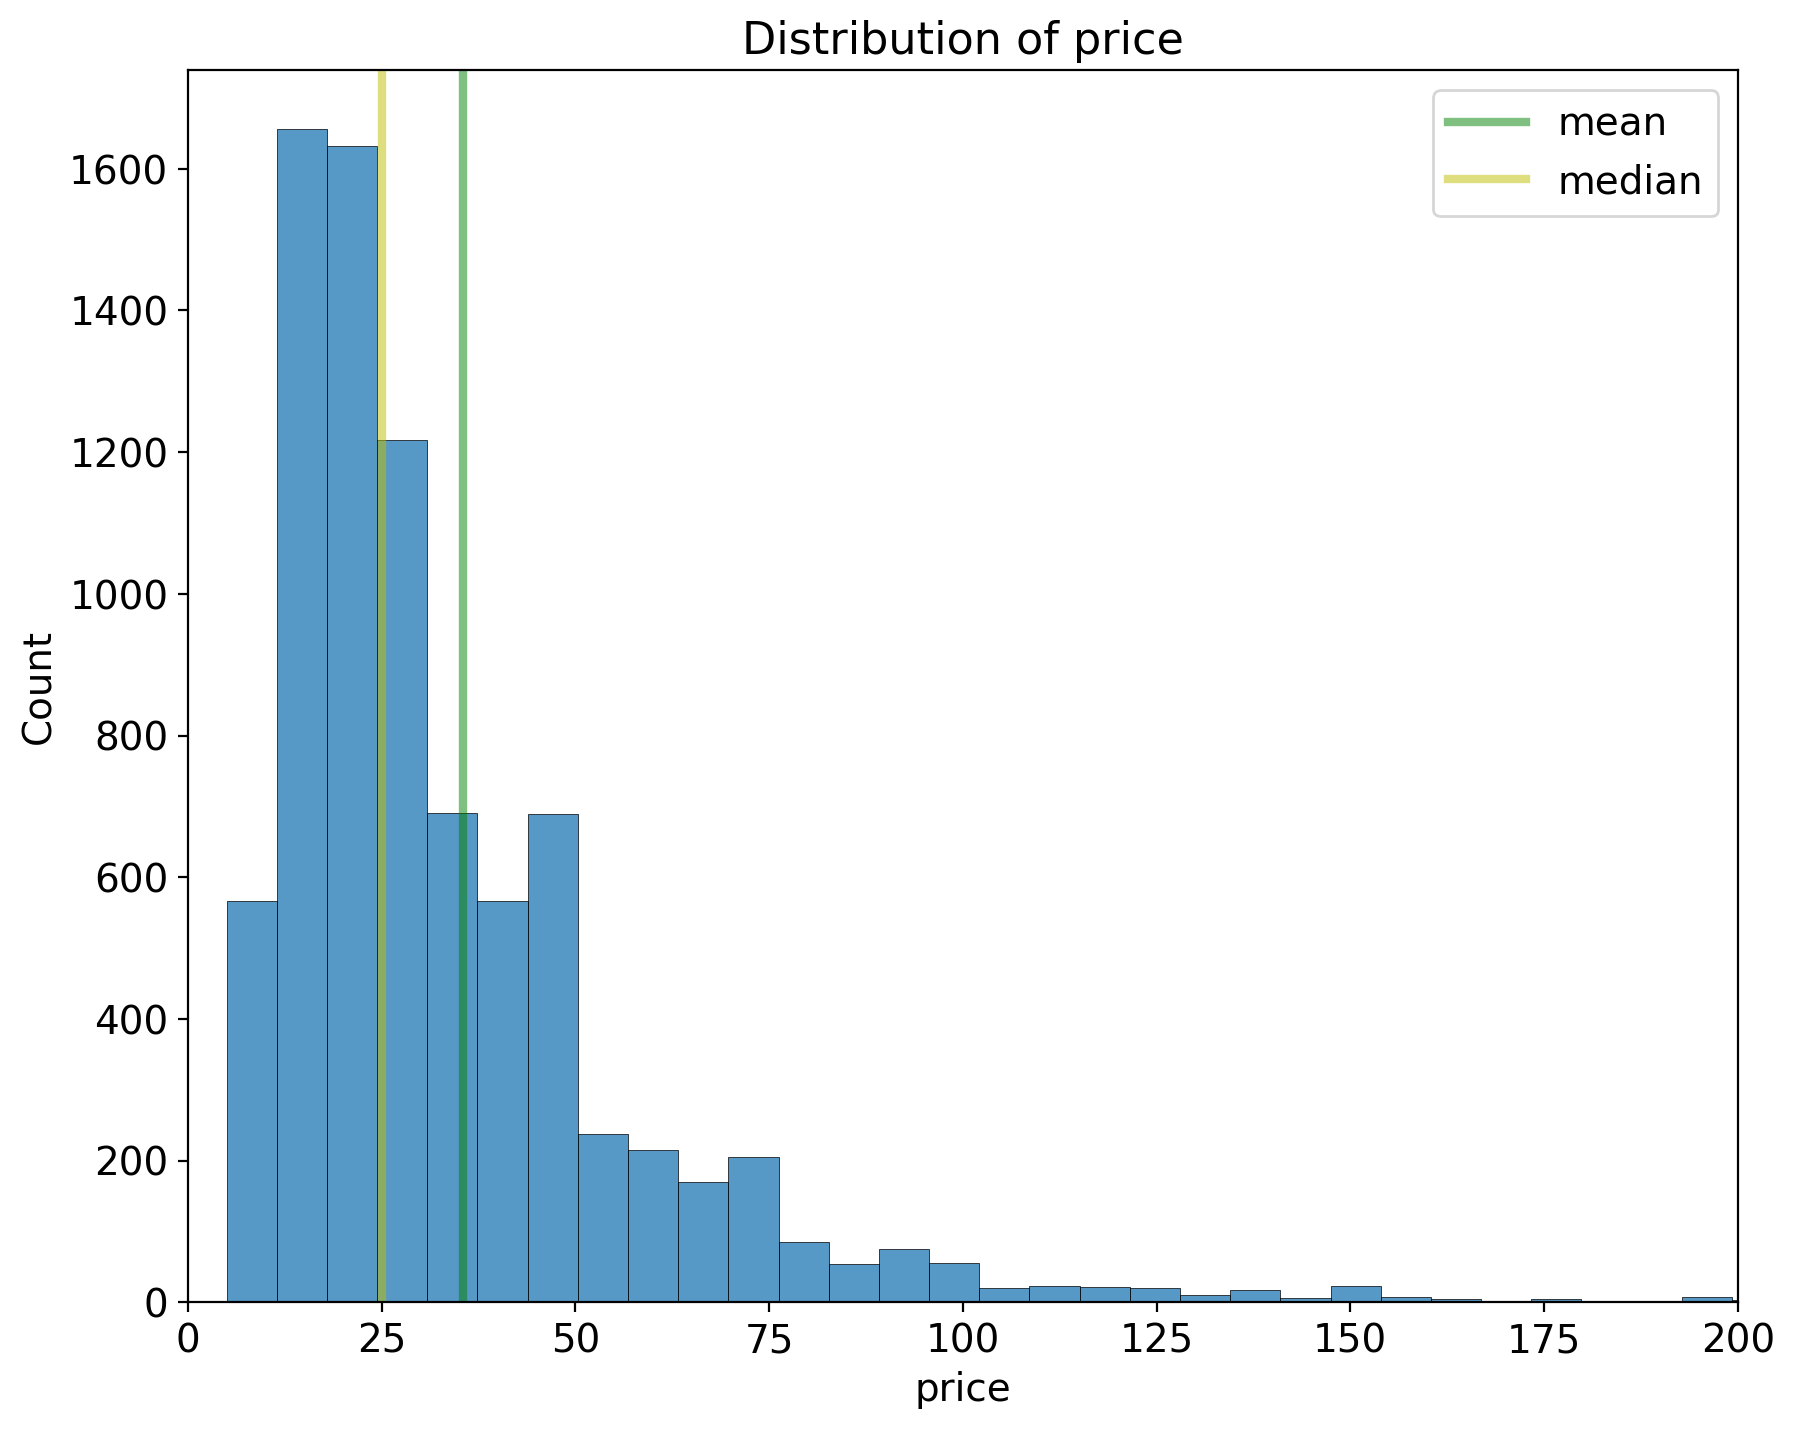

In [25]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "price", 200)
plt.xlim(0,200)

This gives us a better picture of price distribution. It is still a right-skewed distribution but we can more clearly see that most the wine price's are less than 50. Median of the price is 25 and the average price is 35.5.

In order to use price as a predictor, we need to assume a points received of a wine does not cause any price change. Otherwise, price feature would cause data leakage which would spoil our future predictions of points. 

Nonetheless, price is an indicator of wine's quality and age and assuming it is not affected by the points received, it will be an important determiner for the model.

## Distribution of Price in the range 0-200

(0.0, 200.0)

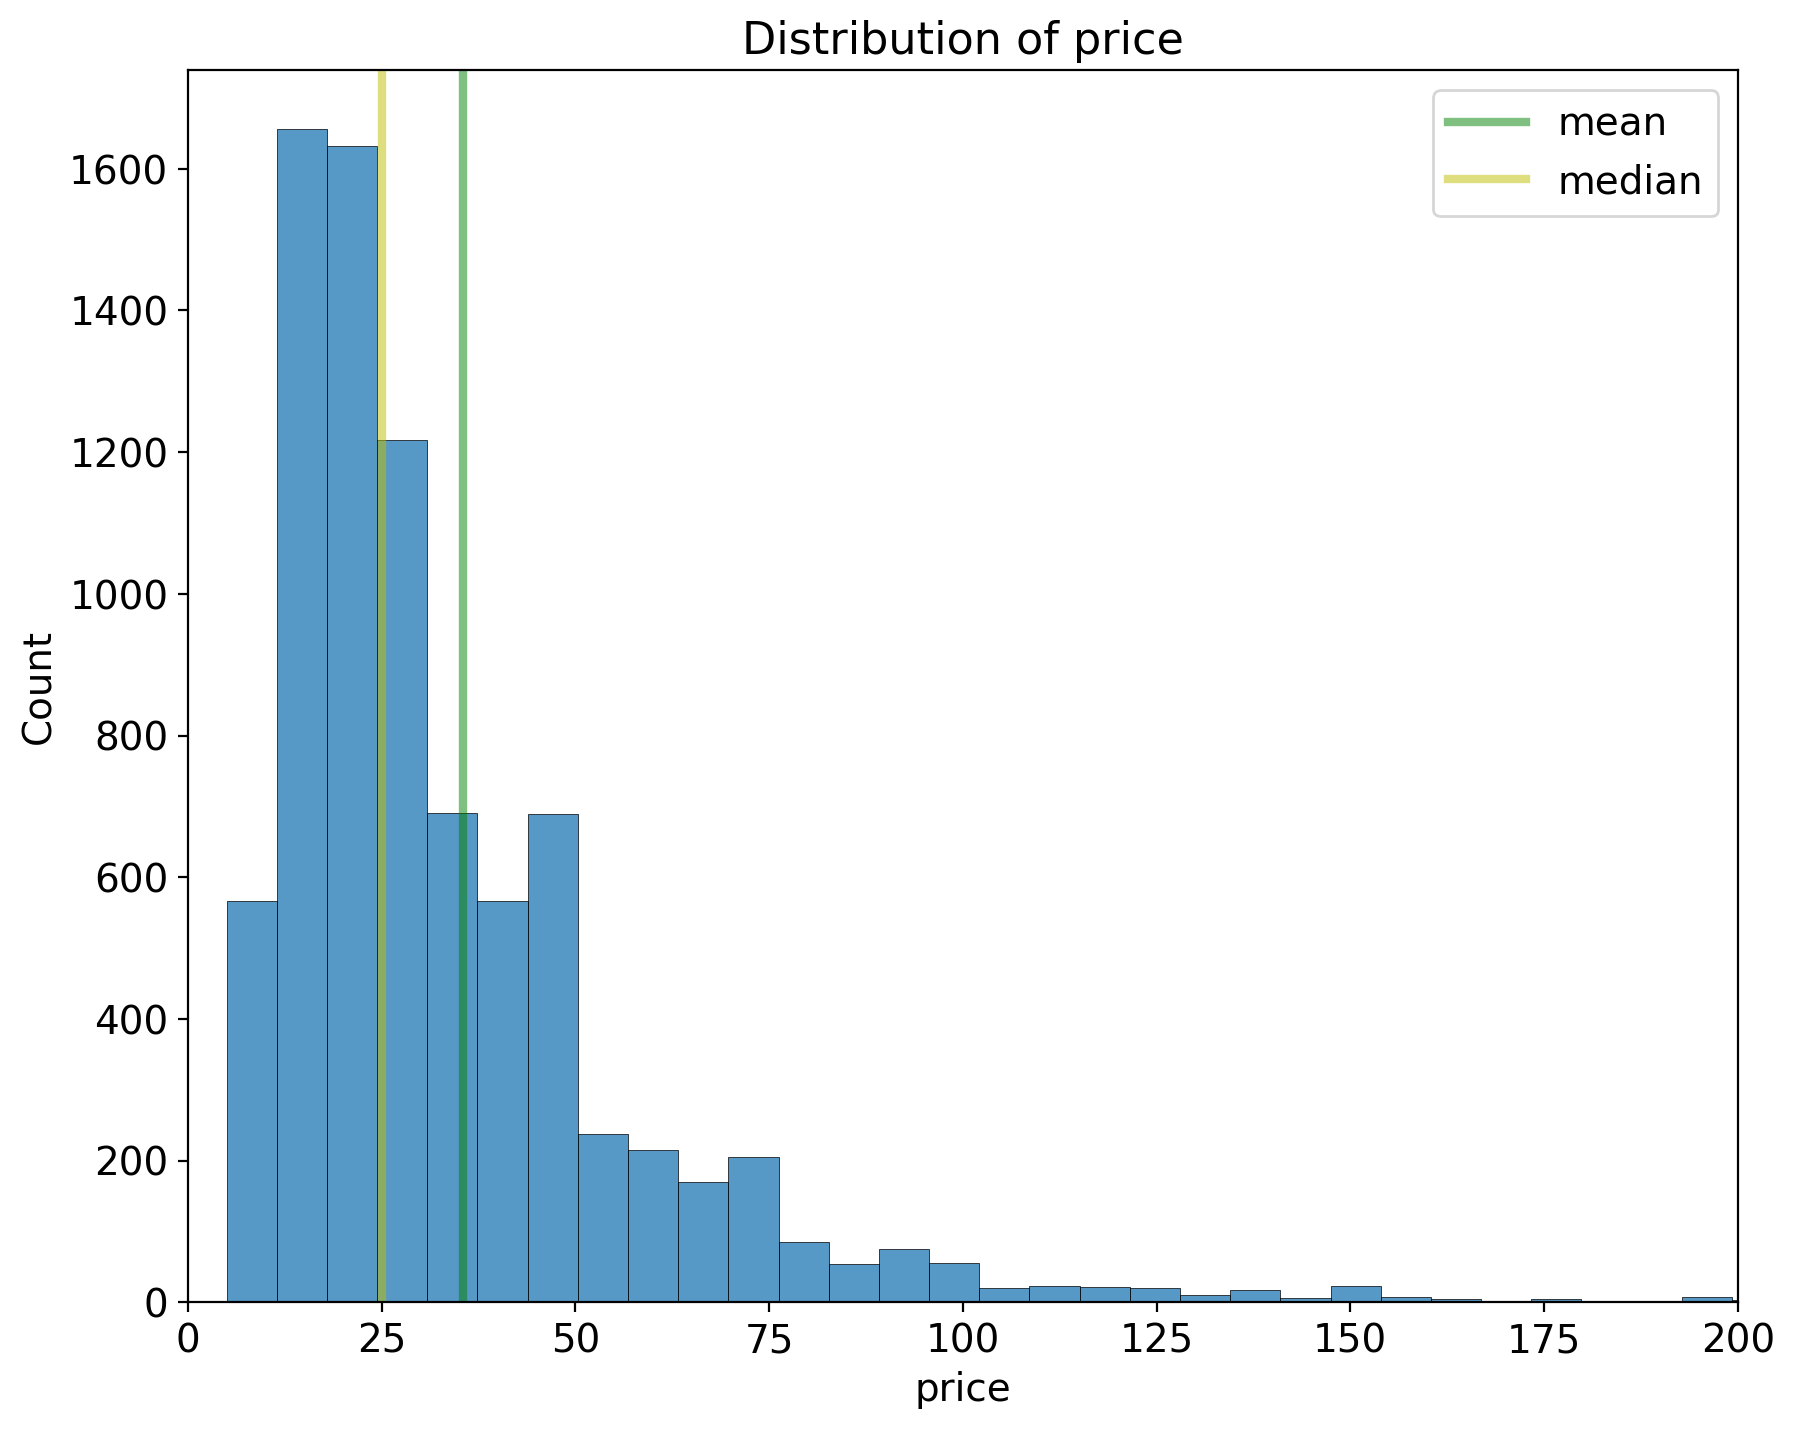

In [26]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "price", 200)
plt.xlim(0,200)

## Points and country

In [27]:
# for understandable plots wines from 
# themost frequent countries' points
# will be visualized
countries = (train_cleaned["country"]
             .value_counts())

freq_countries = list(
    countries[
        countries.values > 300]
    .index)

freq2_countries = list(
    countries[
        (countries.values <= 300) &
        (countries.values >= 100)]
    .index)

<Axes: title={'center': 'Distribution of points per country'}, xlabel='points', ylabel='Density'>

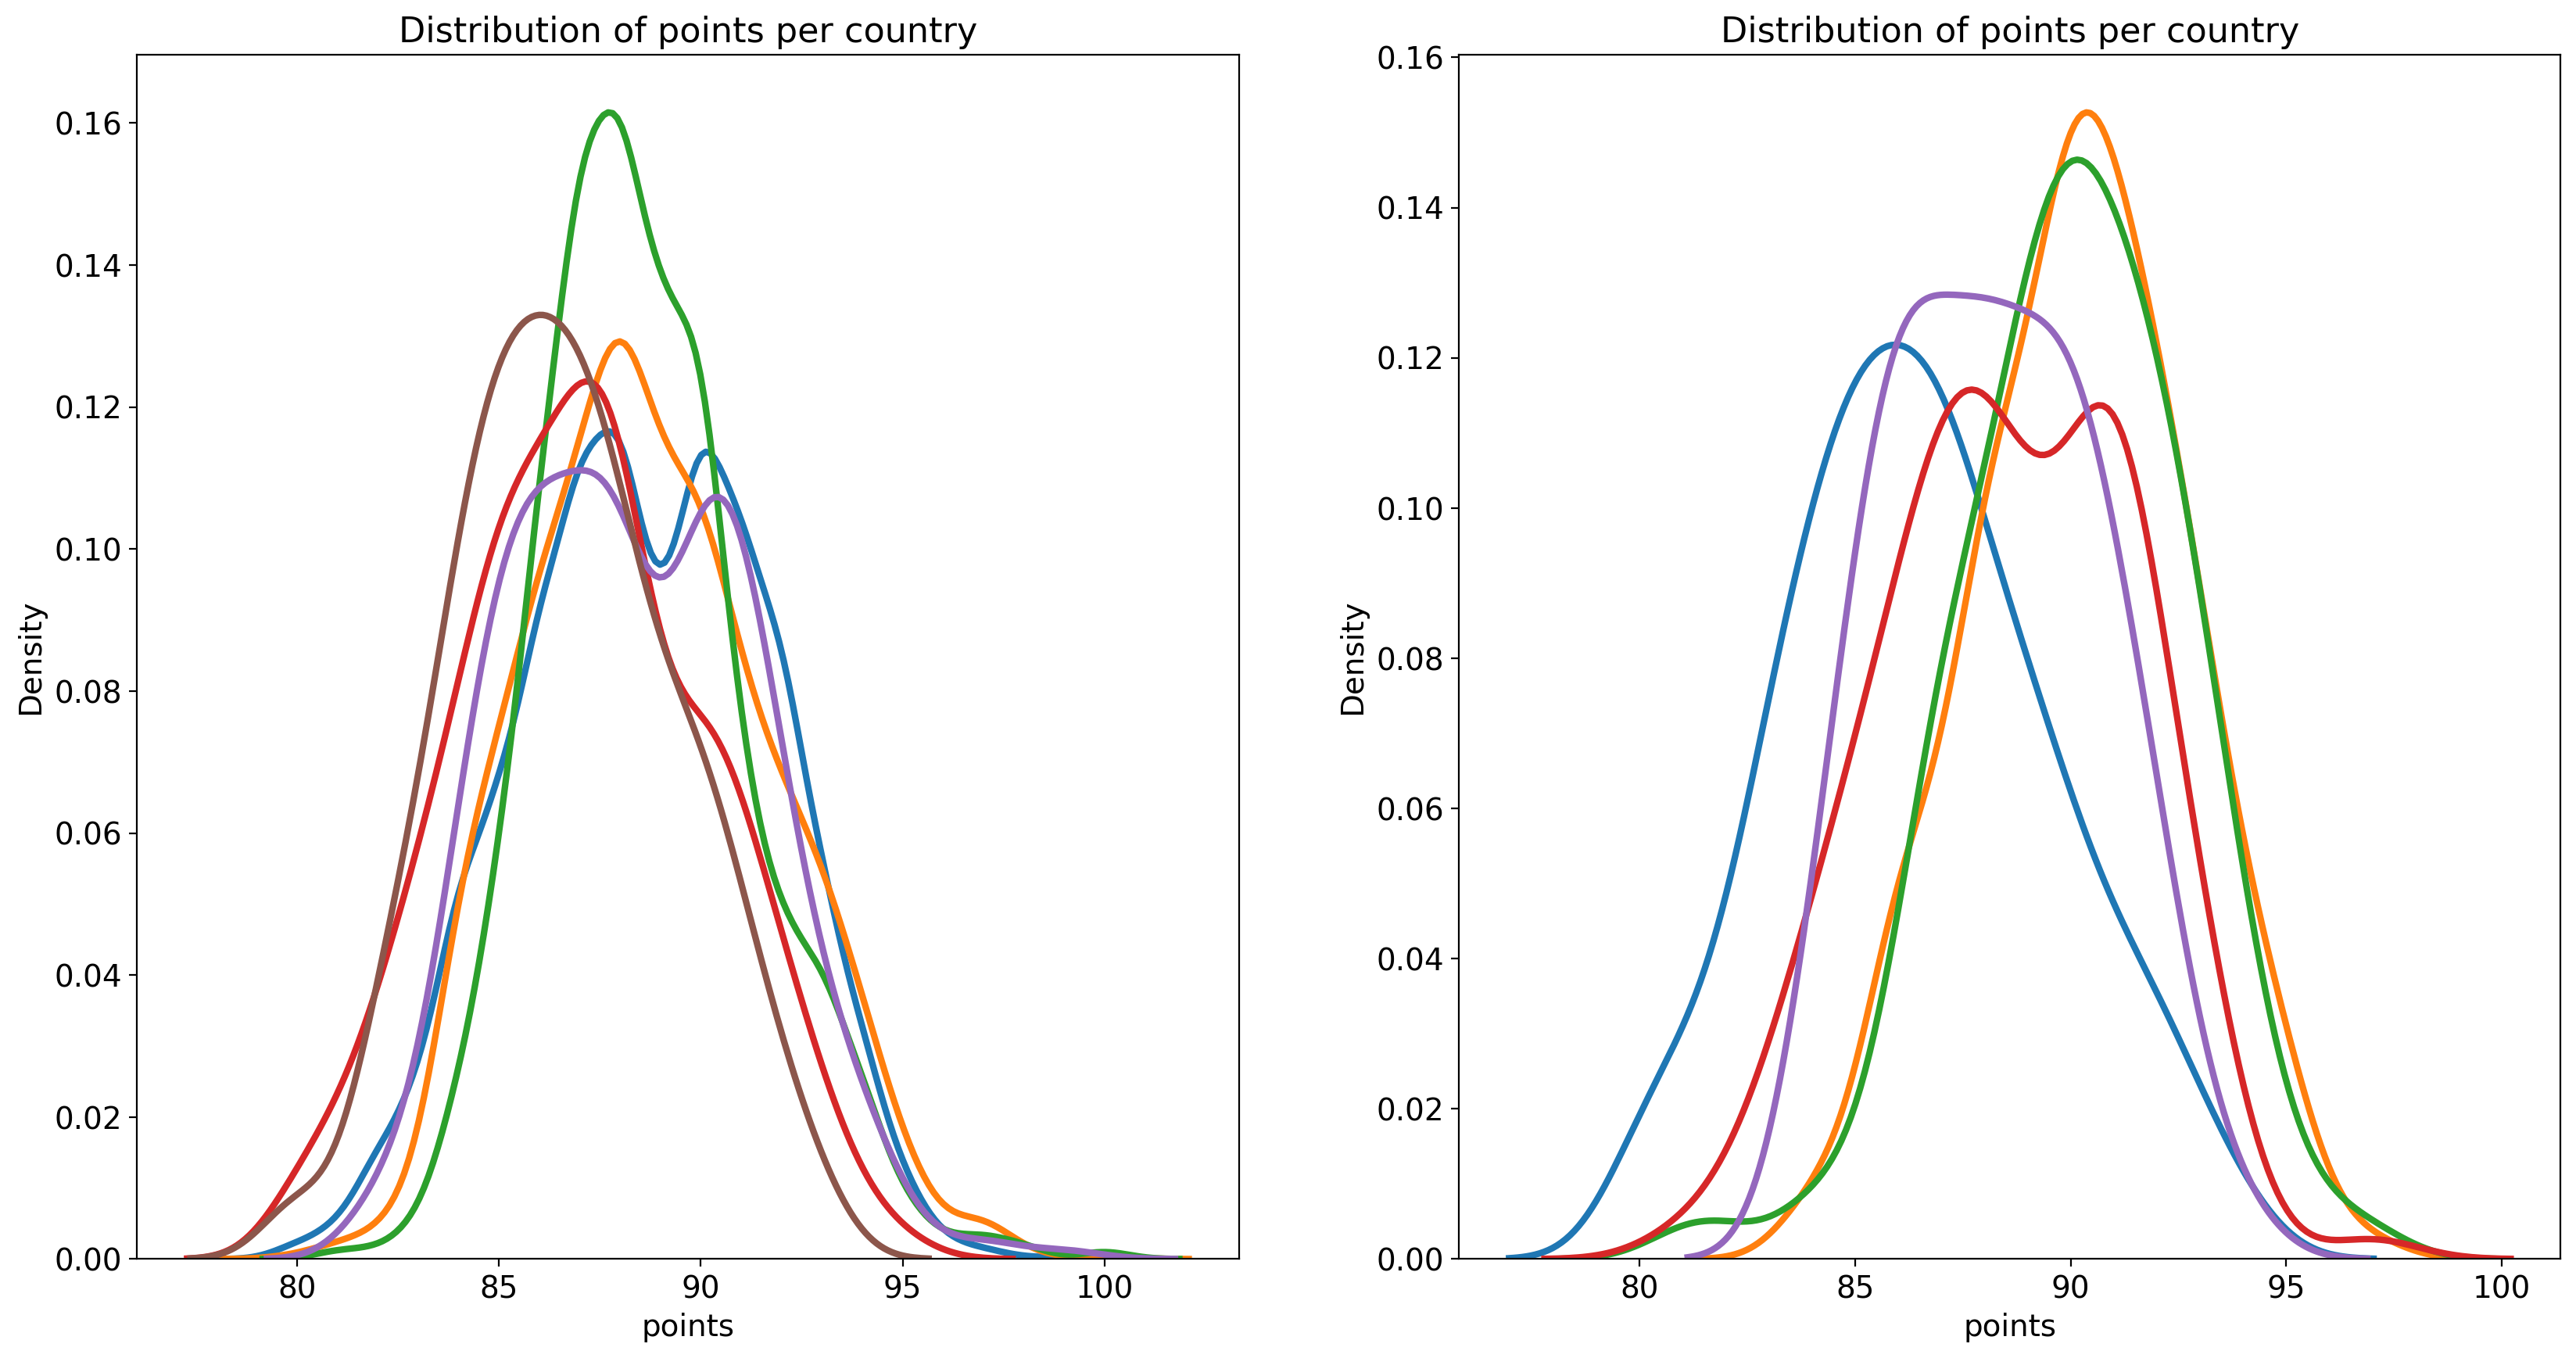

In [28]:
# distribution of the points per country
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for most frequent countries
plt.subplot(1, 2, 1)
plot_distribution(train_cleaned, "points",
                  freq_countries, "country")

# plot points distribution for second most frequent countries
plt.subplot(1, 2, 2)
plot_distribution(train_cleaned, "points",
                  freq2_countries, "country")

Wine producing market is dominated by US, France, Italy and Spain which is easily available from the plots. In general, country is a differentiating feature to determine points of a wine. However, there are some exception country pairs that have same points distribution:

* USA - Portugal
* Austria - Germany
* Argentina - Chili

## Points VS price in most frequent countries

In [29]:
# to select most frequent countries
points_freq_countries = train_cleaned[
    train_cleaned
    .country
    .isin(freq_countries)]

(0.0, 200.0)

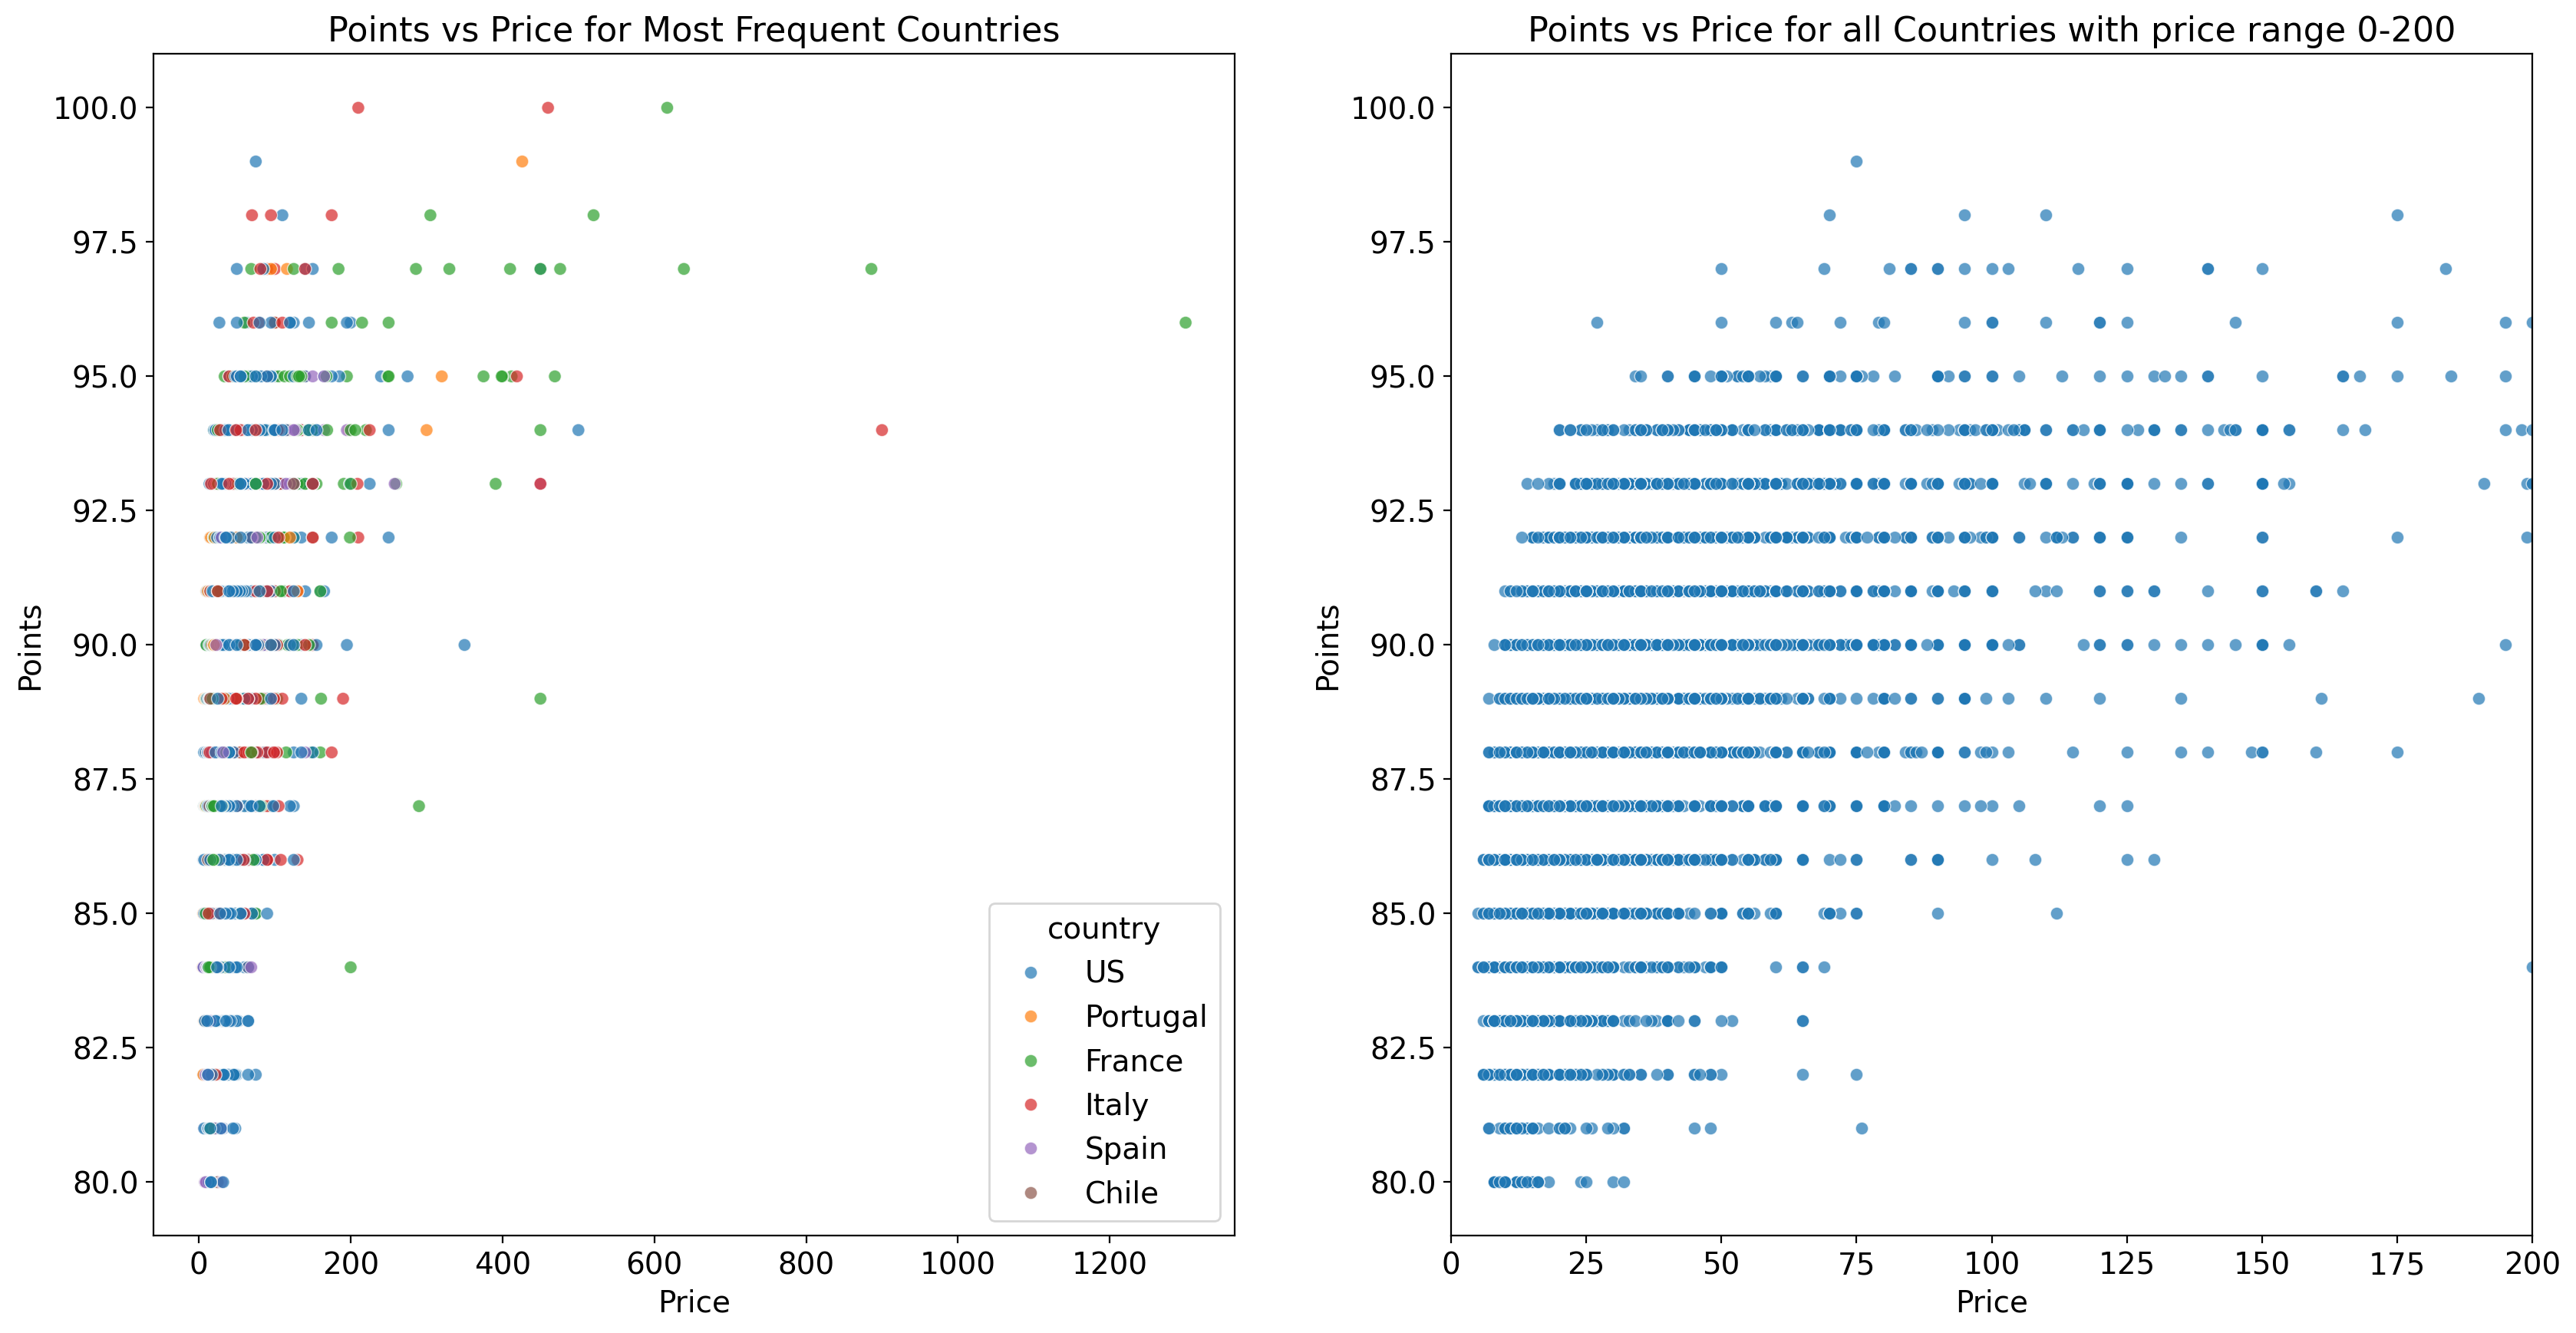

In [30]:
# set plot size and font size
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot a scatterplot of Points and Price
plt.subplot(1,2,1)
sns.scatterplot(x='price', y='points',
                hue='country', 
                data=points_freq_countries,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for Most Frequent Countries", 
          size=16)


# plot a scatterplot of Points and Price
plt.subplot(1,2,2)
sns.scatterplot(x='price', y='points', 
                data=train_cleaned,
                alpha=0.7)

# Plot labeling
plt.xlabel("Price", size=14)
plt.ylabel("Points", size=14)
plt.title("Points vs Price for all Countries with price range 0-200", 
          size=16)
plt.xlim(0,200)

Chart on the left-hand side shows the points and price relationship for the wines produced by US, Portugal, France, Italy, Spain and Chile. Chart on the left hand side shows the points and price relationship for all countries, zoomed in 0 and 200 price range.

Both charts shows there is a positive trend between points and price, which serves as a proof that price is an important predictor.

Some other valuable insights are there are two wines from Italy and one from France that received full points from tasters, all of their prices are greater than 200.

In [31]:
# look at the top wines
train_cleaned[
    train_cleaned["points"] == 100]

,country,description,points,price,province,region_1,taster_name,title,variety
4026,France,This new release from a great vintage for Char...,100,617.0,Champagne,Champagne,Roger Voss,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,Chardonnay
6073,Italy,"A perfect wine from a classic vintage, the 200...",100,460.0,Tuscany,Toscana,NaN,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot
8250,Italy,Thick as molasses and dark as caramelized brow...,100,210.0,Tuscany,Vin Santo di Montepulciano,NaN,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile


## Points VS province in most frequent countries

In [32]:
# make lists of provinces
provinces_us = create_province_list(
    train_cleaned, "US")
provinces_fr = create_province_list(
    train_cleaned, "France")
provinces_it = create_province_list(
    train_cleaned, "Italy")
provinces_es = create_province_list(
    train_cleaned, "Spain")

/tmp/ipykernel_89005/64925899.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(subset[target],
/tmp/ipykernel_89005/64925899.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(subset[target],
/tmp/ipykernel_89005/64925899.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(subset[target],
/tmp/ipykernel_89005/64925899.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(subset[target],


<Axes: title={'center': 'Distribution of points per province'}, xlabel='points', ylabel='Density'>

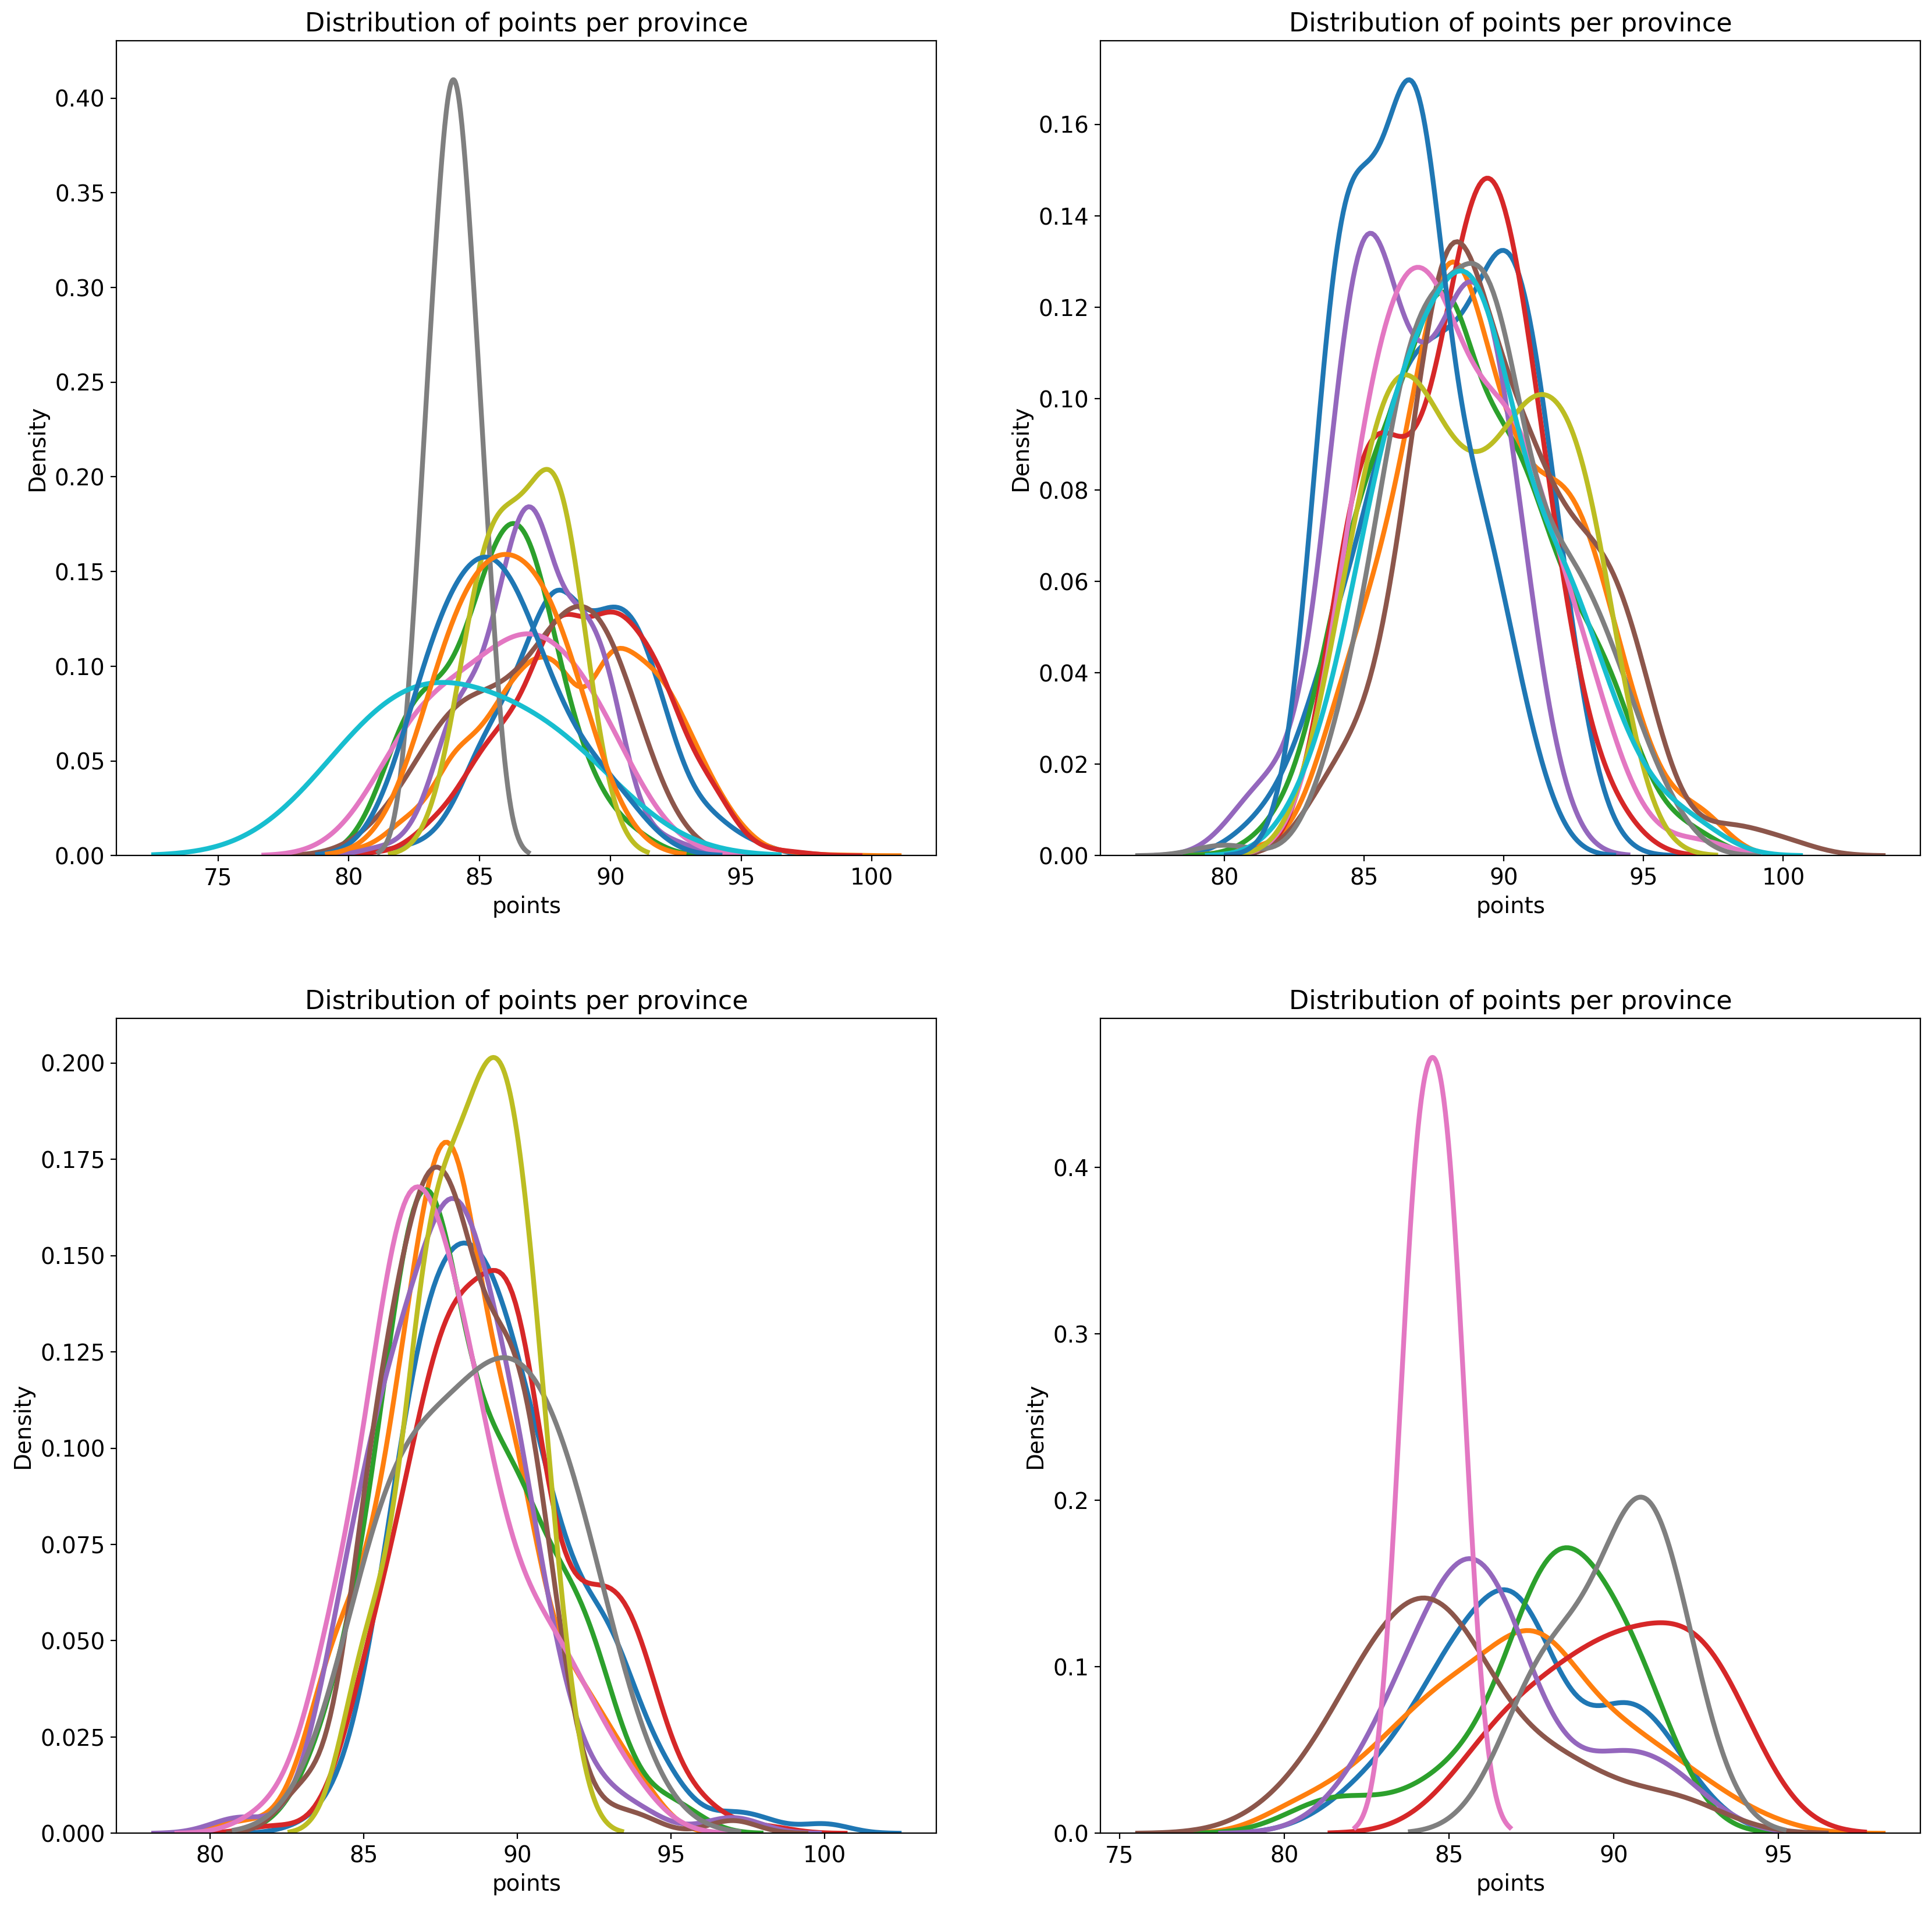

In [33]:
# distribution of provinces
figsize(20, 20)
plt.rcParams['font.size'] = 14

# plot points distribution for provinces
plt.subplot(2,2,1)
plot_distribution(train_cleaned, "points", 
                  provinces_us, "province")

# plot points distribution for provinces
plt.subplot(2,2,2)
plot_distribution(train_cleaned, "points", 
                  provinces_fr, "province")

# plot points distribution for provinces
plt.subplot(2,2,3)
plot_distribution(train_cleaned, "points", 
                  provinces_it, "province")

# plot points distribution for provinces
plt.subplot(2,2,4)
plot_distribution(train_cleaned, "points", 
                  provinces_es, "province")

## Points VS taster_name

/tmp/ipykernel_89005/1560822812.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.set_xticklabels(f.get_xticklabels(),


Text(0.5, 1.0, 'Points from Different Tasters')

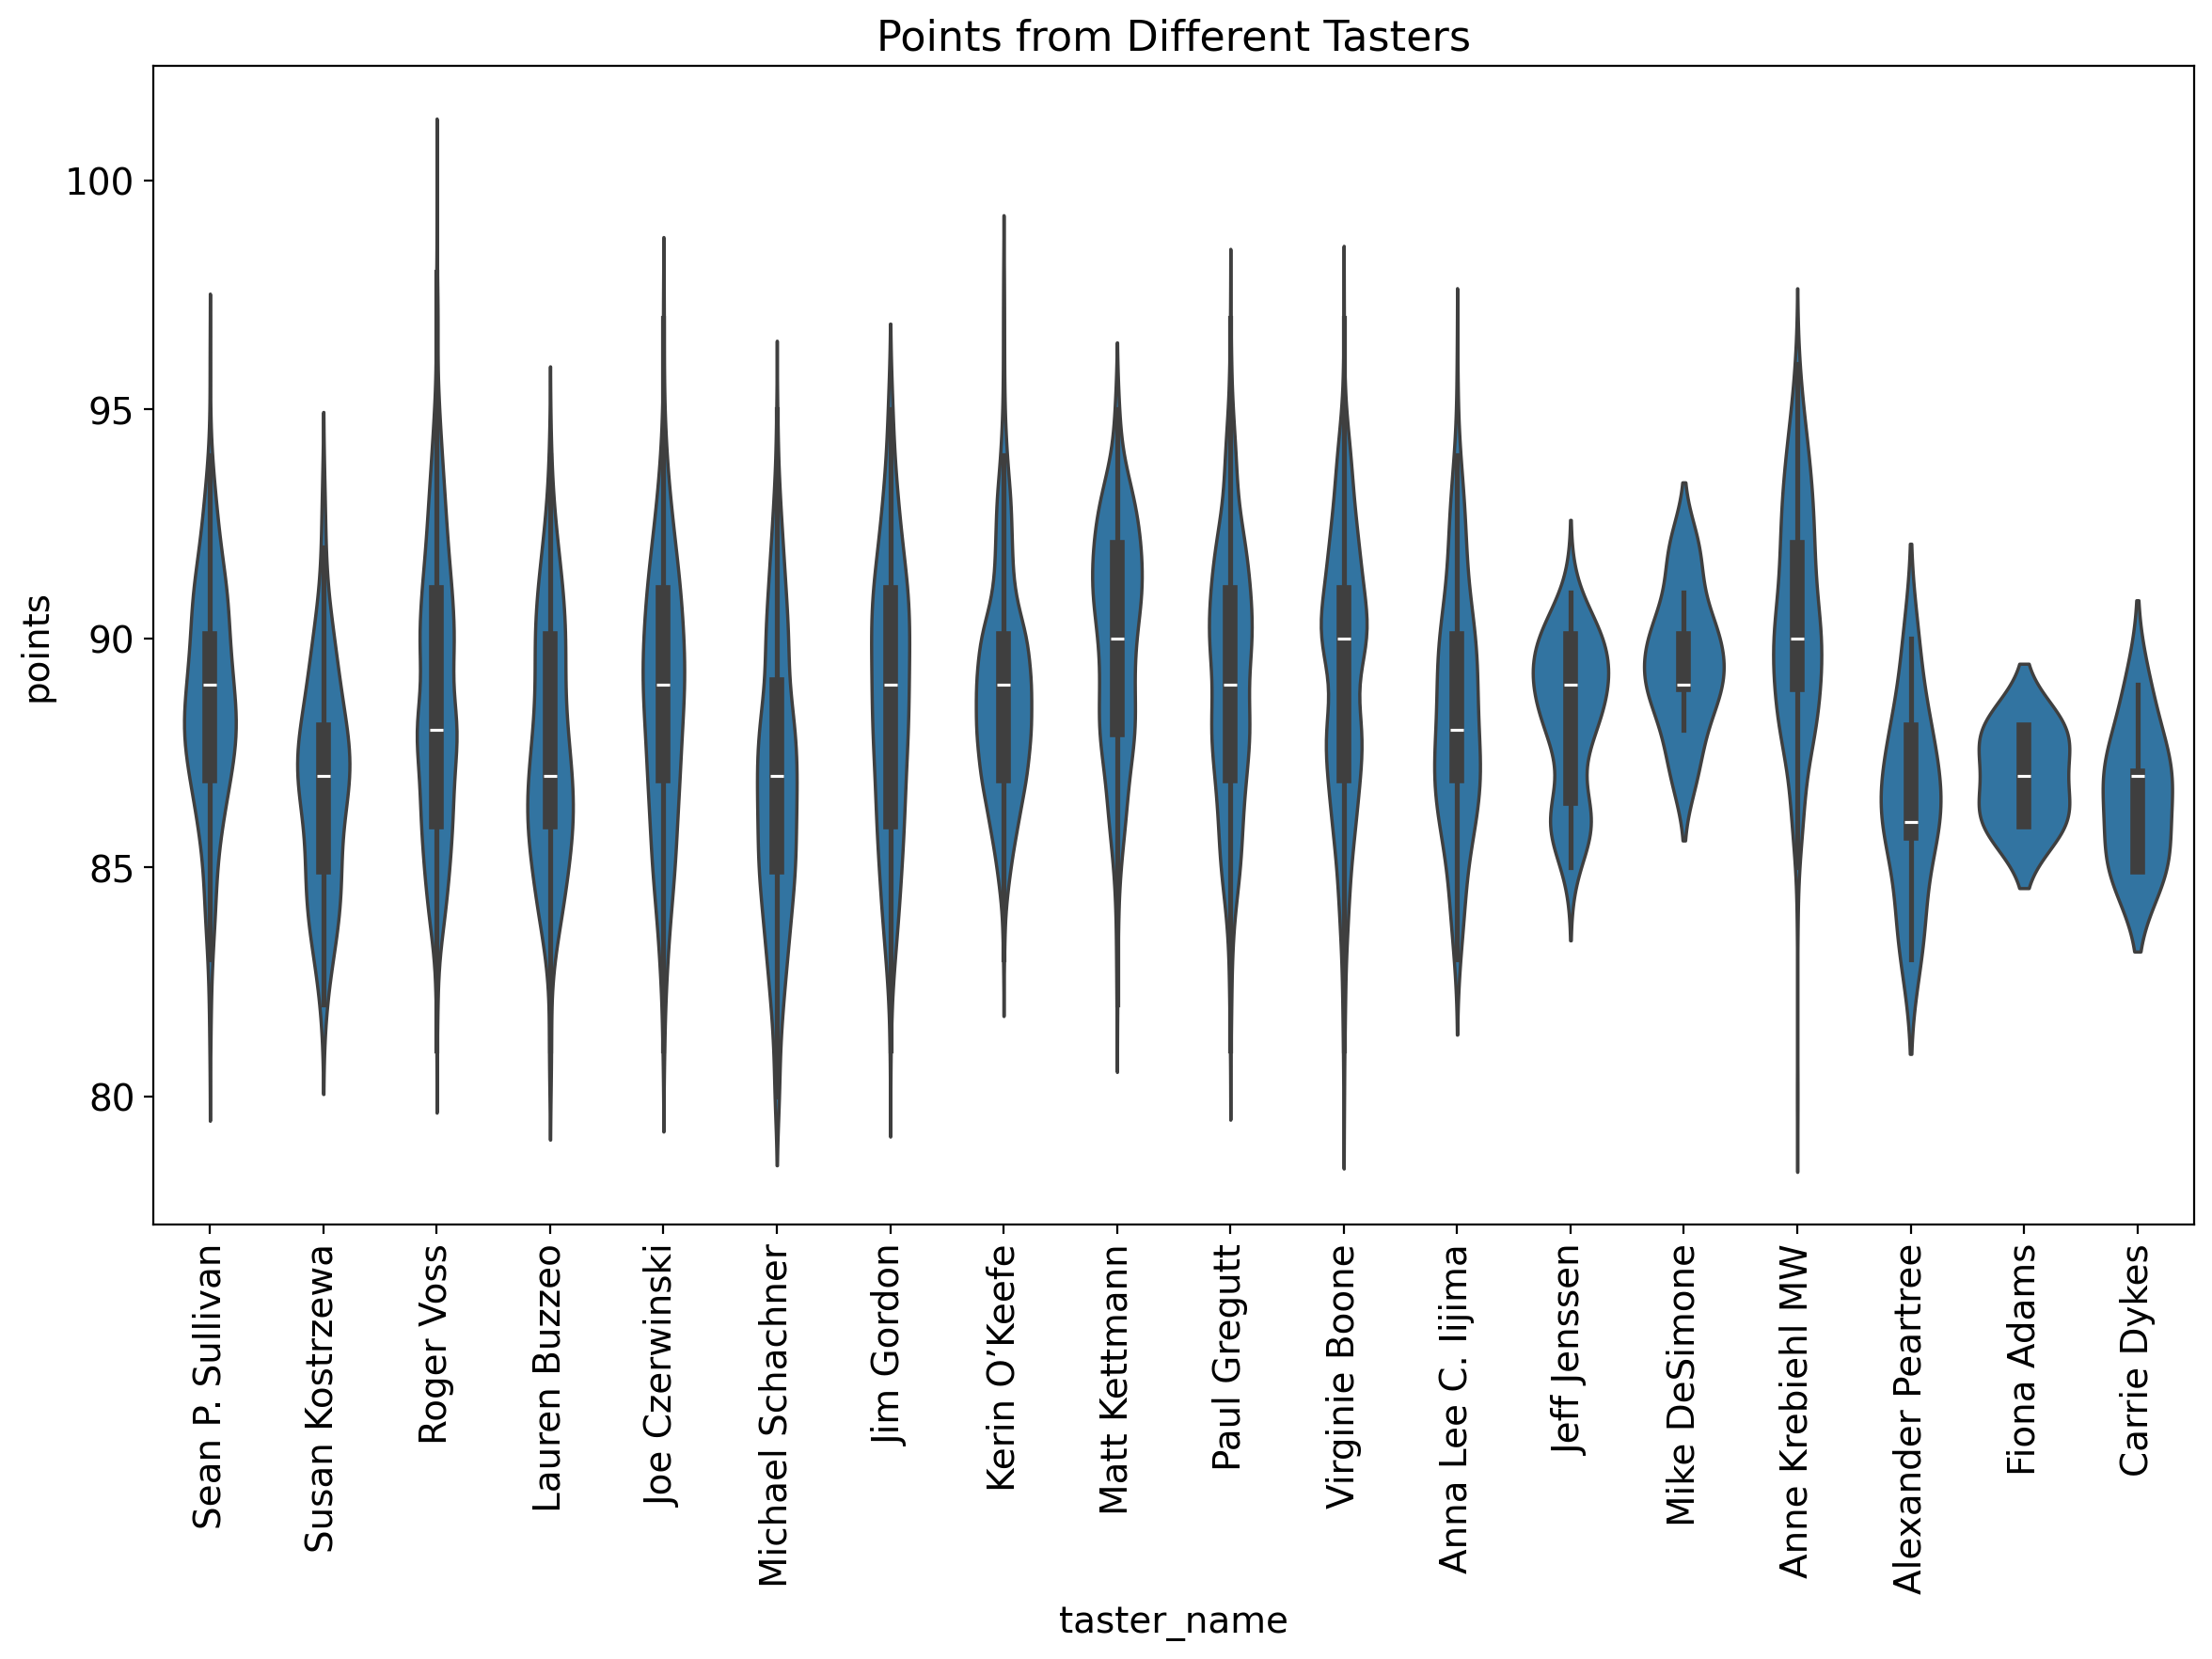

In [34]:
# set plot size and font size
figsize(14, 8)
plt.rcParams['font.size'] = 14

# violin plot to see descriptive statistics 
# and distribution
# per taster_name
f = sns.violinplot(data=train_cleaned,
                   x="taster_name",
                   y="points")

f.set_xticklabels(f.get_xticklabels(),
                  rotation=90)

plt.title("Points from Different Tasters",
          size=16)

Violins shows the distribution of the points and their descriptive statistics together per taster. It is clear that each taster's descriptive statistics and distribution of points are unique.

Looking at this picture, taster_name could be the second most important predictor of a points of a wine.